# 如何用Python优雅的调用R

- @作者：AFAN
- @时间：2025-03-13
- @B站：AFAN的费曼生活
- @微信：afan-life
- @github：https://github.com/AFAN-LIFE/AFAN-LIFE
- @知识星球（付费分享）：AFAN的金融科技
- *注：本分享来自于AFAN的公开分享，转载请注明出处

R安装：install.packages("lazyeval")

In [2]:
import os
import io
import pandas as pd
os.environ['R_HOME'] = r'D:\software\R-4.4.1'   # R安装路径
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from IPython.display import Image
import rpy2.robjects.lib.ggplot2 as ggplot2

D:\software\anaconda3\envs\medical\Lib\site-packages\rpy2\robjects\lib\ggplot2.py:70: UserWarning: This was designed against ggplot2 versions starting with 3.3. but you have 3.5.1
  warnings.warn(


# 直接传输df

In [2]:
# 创建R环境
r = ro.r

# 执行修正后的R代码
r('''
Sys.setlocale("LC_ALL", "en_US.UTF-8")  # 设置R的字符编码为UTF-8
library(rms)
r_df <- read.csv("train.csv")
# 验证数据格式
print(class(r_df))  # 应显示"data.frame"
print(colnames(r_df))  # 检查列名

# 构建模型（注意使用正确的数据对象）
model <- lrm(Heart_Disease ~ ., data = r_df)

# 生成预测概率
probabilities <- predict(model, type="fitted")

# 计算分类结果和准确率
predicted_class <- ifelse(probabilities > 0.5, 1, 0)
accuracy <- mean(predicted_class == r_df$Heart_Disease, na.rm=TRUE)

# 保存结果到R环境
result_list <- list(
    model_summary = capture.output(print(model)),
    accuracy = accuracy
)
''')

R[write to console]: 载入需要的程序包：Hmisc

R[write to console]: 
载入程序包：'Hmisc'


R[write to console]: The following objects are masked from 'package:base':

    format.pval, units




[1] "data.frame"
[1] "Age"            "Blood_Sugar"    "Blood_Pressure" "Weight"        
[5] "Heart_Disease" 


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In Sys.setlocale("LC_ALL", "en_US.UTF-8") :
R[write to console]: 
 
R[write to console]:  using locale code page other than 936 may cause problems

R[write to console]: 2: 程序包'rms'是用R版本4.4.2 来建造的 

R[write to console]: 3: 程序包'Hmisc'是用R版本4.4.2 来建造的 



In [3]:
# 获取结果
results = ro.globalenv['result_list']
print("\n模型摘要：")
print('\n'.join(results[0]))
print(f"\n模型准确率：{round(results[1][0], 4)}")


模型摘要：
Logistic Regression Model

lrm(formula = Heart_Disease ~ ., data = r_df)

                       Model Likelihood     Discrimination    Rank Discrim.    
                             Ratio Test            Indexes          Indexes    
Obs          1000    LR chi2     238.07     R2       0.859    C       0.997    
 0            968    d.f.             4    R2(4,1000)0.209    Dxy     0.994    
 1             32    Pr(> chi2) <0.0001    R2(4,92.9)0.919    gamma   0.994    
max |deriv| 2e-05                           Brier    0.007    tau-a   0.062    

               Coef      S.E.    Wald Z Pr(>|Z|)
Intercept      -109.6707 24.8000 -4.42  <0.0001 
Age               0.4953  0.1116  4.44  <0.0001 
Blood_Sugar       0.5558  0.1228  4.52  <0.0001 
Blood_Pressure    0.0135  0.0213  0.63  0.5270  
Weight            0.0647  0.0307  2.11  0.0352  


模型准确率：0.991


# 传输Pandsa的df

In [3]:
# 启用自动转换Pandas DataFrame到R数据框
pandas2ri.activate()

# 加载所需的R包
try:
    rms = importr('rms')
except:
    # 如果未安装则自动安装（首次运行需要）
    utils = importr('utils')
    utils.install_packages('rms')
    rms = importr('rms')

In [4]:
# 准备示例数据（替换为你的实际数据）
data = pd.read_csv("train.csv")

# 将Python数据框转换为R数据框（使用不同变量名避免冲突）
with ro.conversion.localconverter(ro.default_converter + pandas2ri.converter) as cv:
    r_data = ro.conversion.py2rpy(data)  # 假设data是你的Pandas DataFrame

# 将转换后的数据赋值到R环境（变量名改为r_df避免冲突）
ro.globalenv['r_df'] = r_data

In [5]:
print(ro.globalenv)

<environment: R_GlobalEnv>



In [6]:
# 创建R环境
r = ro.r

# 执行修正后的R代码
r('''
# 验证数据格式
print(class(r_df))  # 应显示"data.frame"
print(colnames(r_df))  # 检查列名

# 构建模型（注意使用正确的数据对象）
model <- lrm(Heart_Disease ~ ., data = r_df)

# 生成预测概率
probabilities <- predict(model, type="fitted")

# 计算分类结果和准确率
predicted_class <- ifelse(probabilities > 0.5, 1, 0)
accuracy <- mean(predicted_class == r_df$Heart_Disease, na.rm=TRUE)

# 保存结果到R环境
result_list <- list(
    model_summary = capture.output(print(model)),
    accuracy = accuracy
)
''')

[1] "data.frame"
[1] "Age"            "Blood_Sugar"    "Blood_Pressure" "Weight"        
[5] "Heart_Disease" 


In [7]:
# 获取结果
results = ro.globalenv['result_list']
print("\n模型摘要：")
print('\n'.join(results[0]))
print(f"\n模型准确率：{round(results[1][0], 4)}")


模型摘要：
Logistic Regression Model

lrm(formula = Heart_Disease ~ ., data = r_df)

                       Model Likelihood     Discrimination    Rank Discrim.    
                             Ratio Test            Indexes          Indexes    
Obs          1000    LR chi2     238.07     R2       0.859    C       0.997    
 0            968    d.f.             4    R2(4,1000)0.209    Dxy     0.994    
 1             32    Pr(> chi2) <0.0001    R2(4,92.9)0.919    gamma   0.994    
max |deriv| 2e-05                           Brier    0.007    tau-a   0.062    

               Coef      S.E.    Wald Z Pr(>|Z|)
Intercept      -109.6707 24.8000 -4.42  <0.0001 
Age               0.4953  0.1116  4.44  <0.0001 
Blood_Sugar       0.5558  0.1228  4.52  <0.0001 
Blood_Pressure    0.0135  0.0213  0.63  0.5270  
Weight            0.0647  0.0307  2.11  0.0352  


模型准确率：0.991


In [8]:
# 设置保存路径（使用原始字符串处理Windows路径）
plot_path = r"C:/Users/fsyan/Desktop/python"

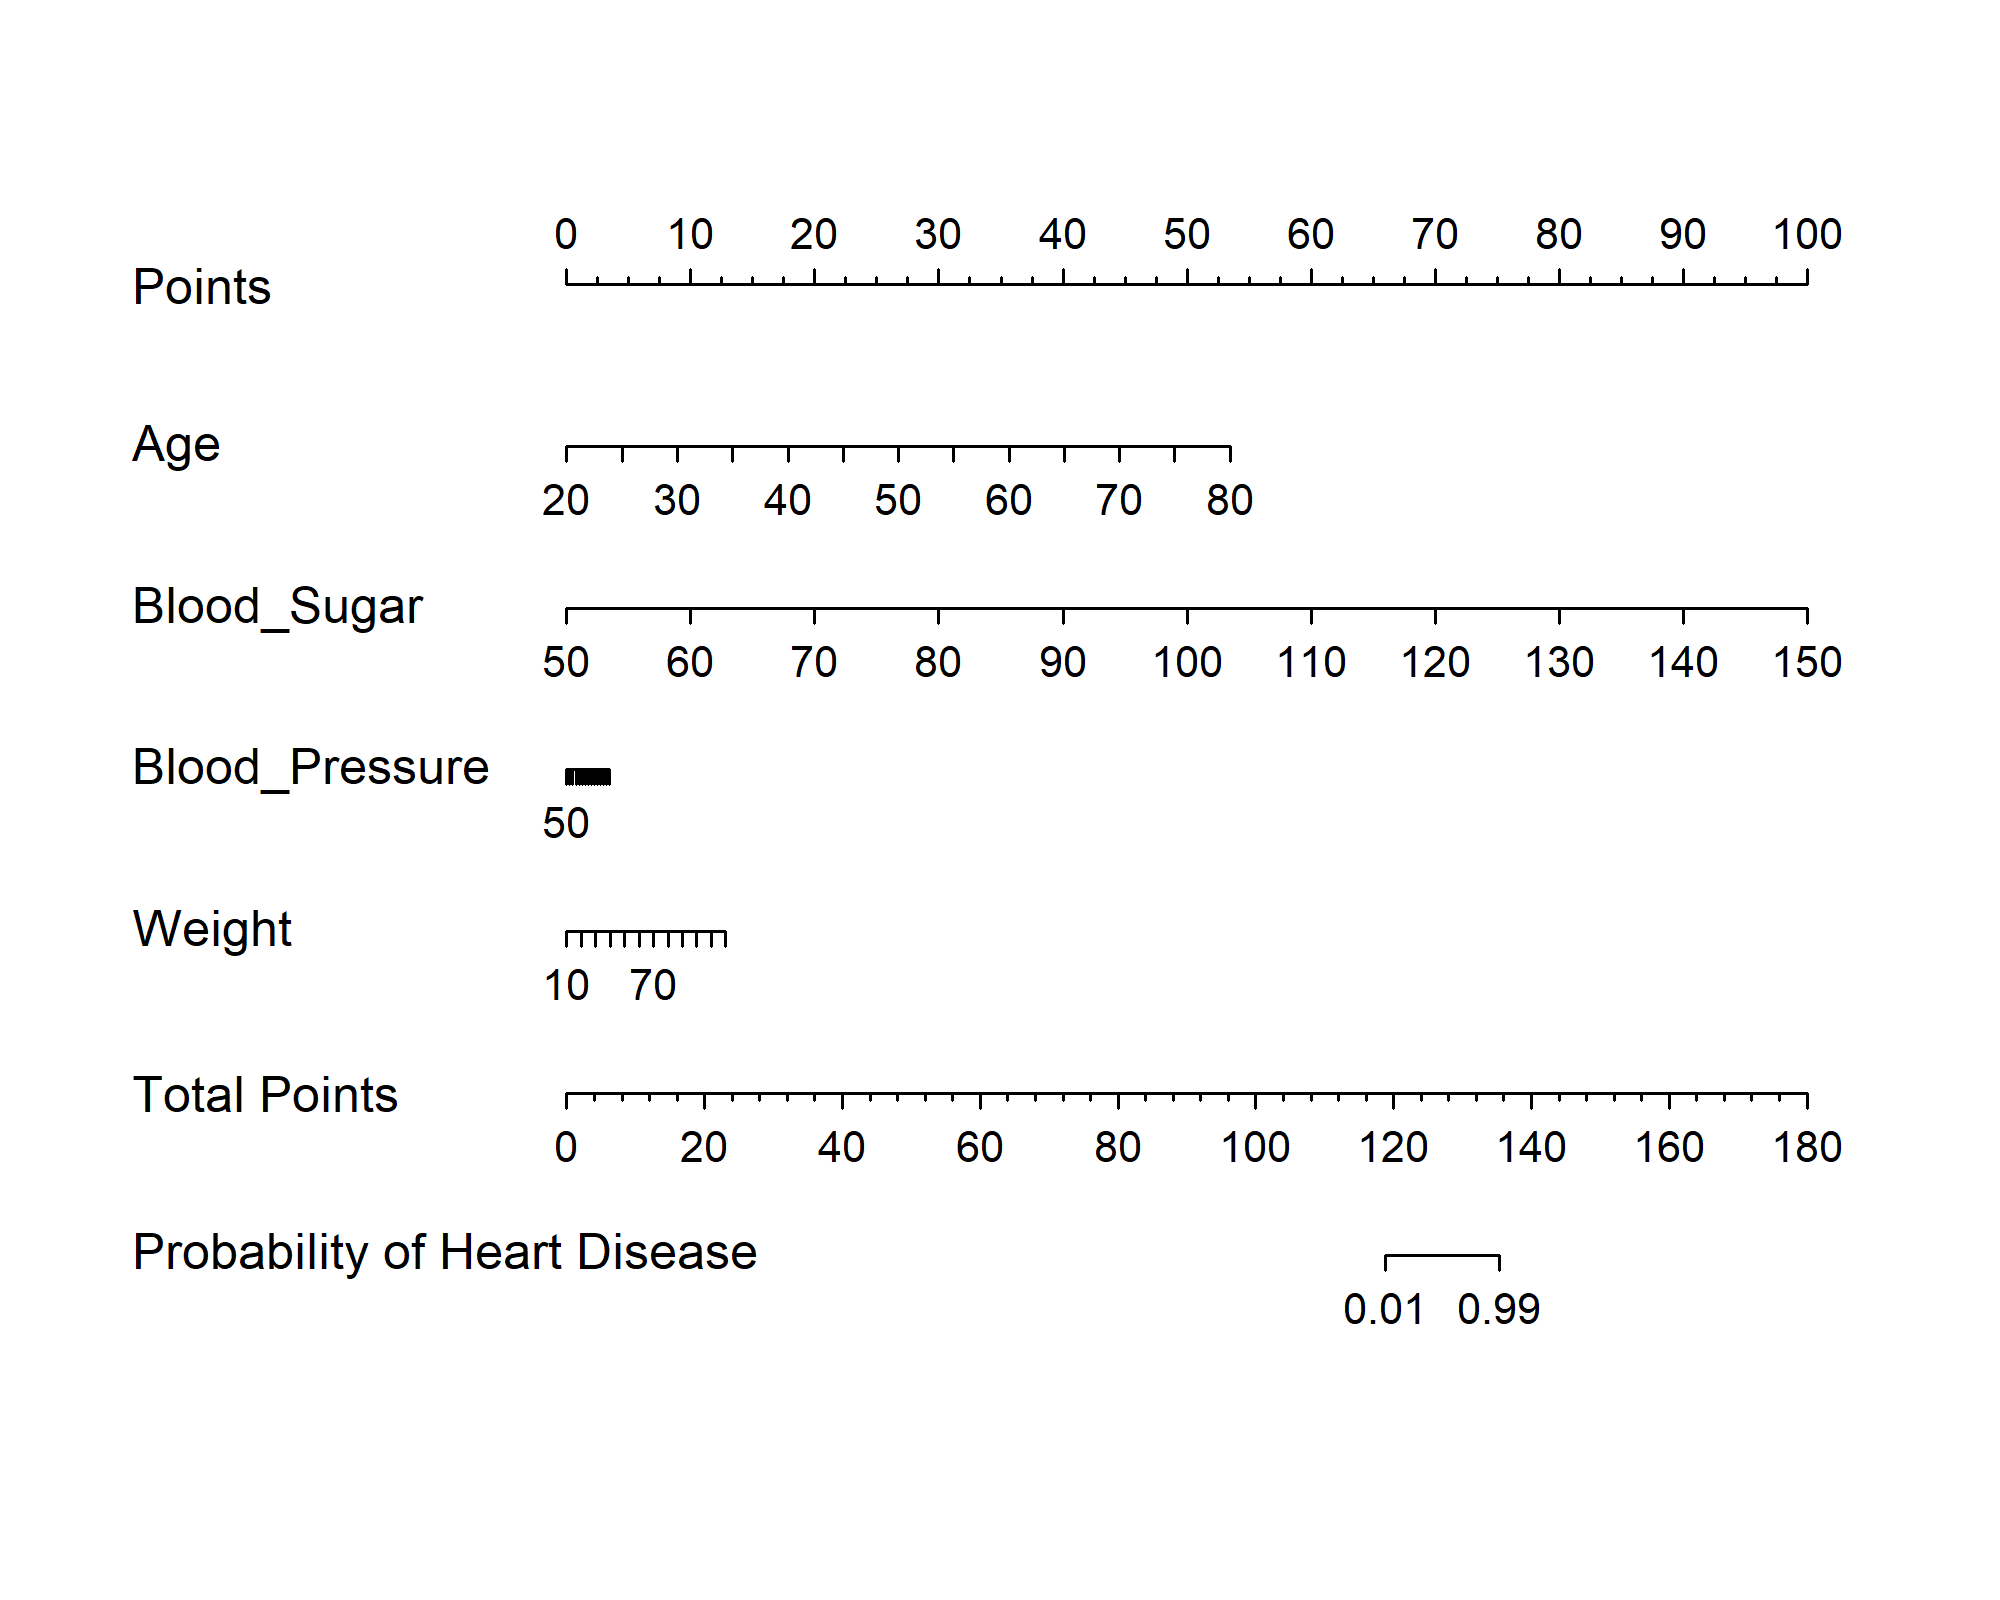

In [10]:
# 生成nom并显示
ro.r('''
dd <- datadist(r_df)
# 设置Total Points的范围
options(datadist = "dd")

png("nom.png", 
    width=2000, 
    height=1600, 
    res=300)  # 高分辨率输出

# 绘制列线图
nom <- nomogram(model, 
                fun = plogis,         # 将模型的logit转化为概率
                funlabel = "Probability of Heart Disease", 
                fun.at=c(0.01, 0.99),
                lp = FALSE)           # 不显示log-odds
# 显示列线图
plot(nom, xlim=c(0, 100))
dev.off()
''')

# 显示图像
display(Image(filename="nom.png"))




# 调用画图保存

In [4]:
# 启用自动转换Pandas DataFrame到R数据框
pandas2ri.activate()

# 加载所需的R包
try:
    rms = importr('rms')
except:
    # 如果未安装则自动安装（首次运行需要）
    utils = importr('utils')
    utils.install_packages('rms')
    rms = importr('rms')

In [5]:
# 准备示例数据（替换为你的实际数据）
data = pd.read_csv("train.csv")

# 将Python数据框转换为R数据框（使用不同变量名避免冲突）
with ro.conversion.localconverter(ro.default_converter + pandas2ri.converter) as cv:
    r_data = ro.conversion.py2rpy(data)  # 假设data是你的Pandas DataFrame

# 将转换后的数据赋值到R环境（变量名改为r_df避免冲突）
ro.globalenv['r_df'] = r_data

In [6]:
print(ro.globalenv)

<environment: R_GlobalEnv>



In [7]:
# 创建R环境
r = ro.r

# 执行修正后的R代码
r('''
# 验证数据格式
print(class(r_df))  # 应显示"data.frame"
print(colnames(r_df))  # 检查列名

# 构建模型（注意使用正确的数据对象）
model <- lrm(Heart_Disease ~ ., data = r_df)

# 生成预测概率
probabilities <- predict(model, type="fitted")

# 计算分类结果和准确率
predicted_class <- ifelse(probabilities > 0.5, 1, 0)
accuracy <- mean(predicted_class == r_df$Heart_Disease, na.rm=TRUE)

# 保存结果到R环境
result_list <- list(
    model_summary = capture.output(print(model)),
    accuracy = accuracy
)
''')

[1] "data.frame"
[1] "Age"            "Blood_Sugar"    "Blood_Pressure" "Weight"        
[5] "Heart_Disease" 


In [8]:
# 获取结果
results = ro.globalenv['result_list']
print("\n模型摘要：")
print('\n'.join(results[0]))
print(f"\n模型准确率：{round(results[1][0], 4)}")


模型摘要：
Logistic Regression Model

lrm(formula = Heart_Disease ~ ., data = r_df)

                       Model Likelihood     Discrimination    Rank Discrim.    
                             Ratio Test            Indexes          Indexes    
Obs          1000    LR chi2     238.07     R2       0.859    C       0.997    
 0            968    d.f.             4    R2(4,1000)0.209    Dxy     0.994    
 1             32    Pr(> chi2) <0.0001    R2(4,92.9)0.919    gamma   0.994    
max |deriv| 2e-05                           Brier    0.007    tau-a   0.062    

               Coef      S.E.    Wald Z Pr(>|Z|)
Intercept      -109.6707 24.8000 -4.42  <0.0001 
Age               0.4953  0.1116  4.44  <0.0001 
Blood_Sugar       0.5558  0.1228  4.52  <0.0001 
Blood_Pressure    0.0135  0.0213  0.63  0.5270  
Weight            0.0647  0.0307  2.11  0.0352  


模型准确率：0.991


In [11]:
# 设置保存路径（使用原始字符串处理Windows路径）
plot_path = r"."

In [12]:
# 生成nom并显示
ro.r('''
dd <- datadist(r_df)
# 设置Total Points的范围
options(datadist = "dd")

png("nom.png", 
    width=2000, 
    height=1600, 
    res=300)  # 高分辨率输出

# 绘制列线图
nom <- nomogram(model, 
                fun = plogis,         # 将模型的logit转化为概率
                funlabel = "Probability of Heart Disease", 
                fun.at=c(0.01, 0.99),
                lp = FALSE)           # 不显示log-odds
# 显示列线图
plot(nom, xlim=c(0, 100))
dev.off()
''')

1


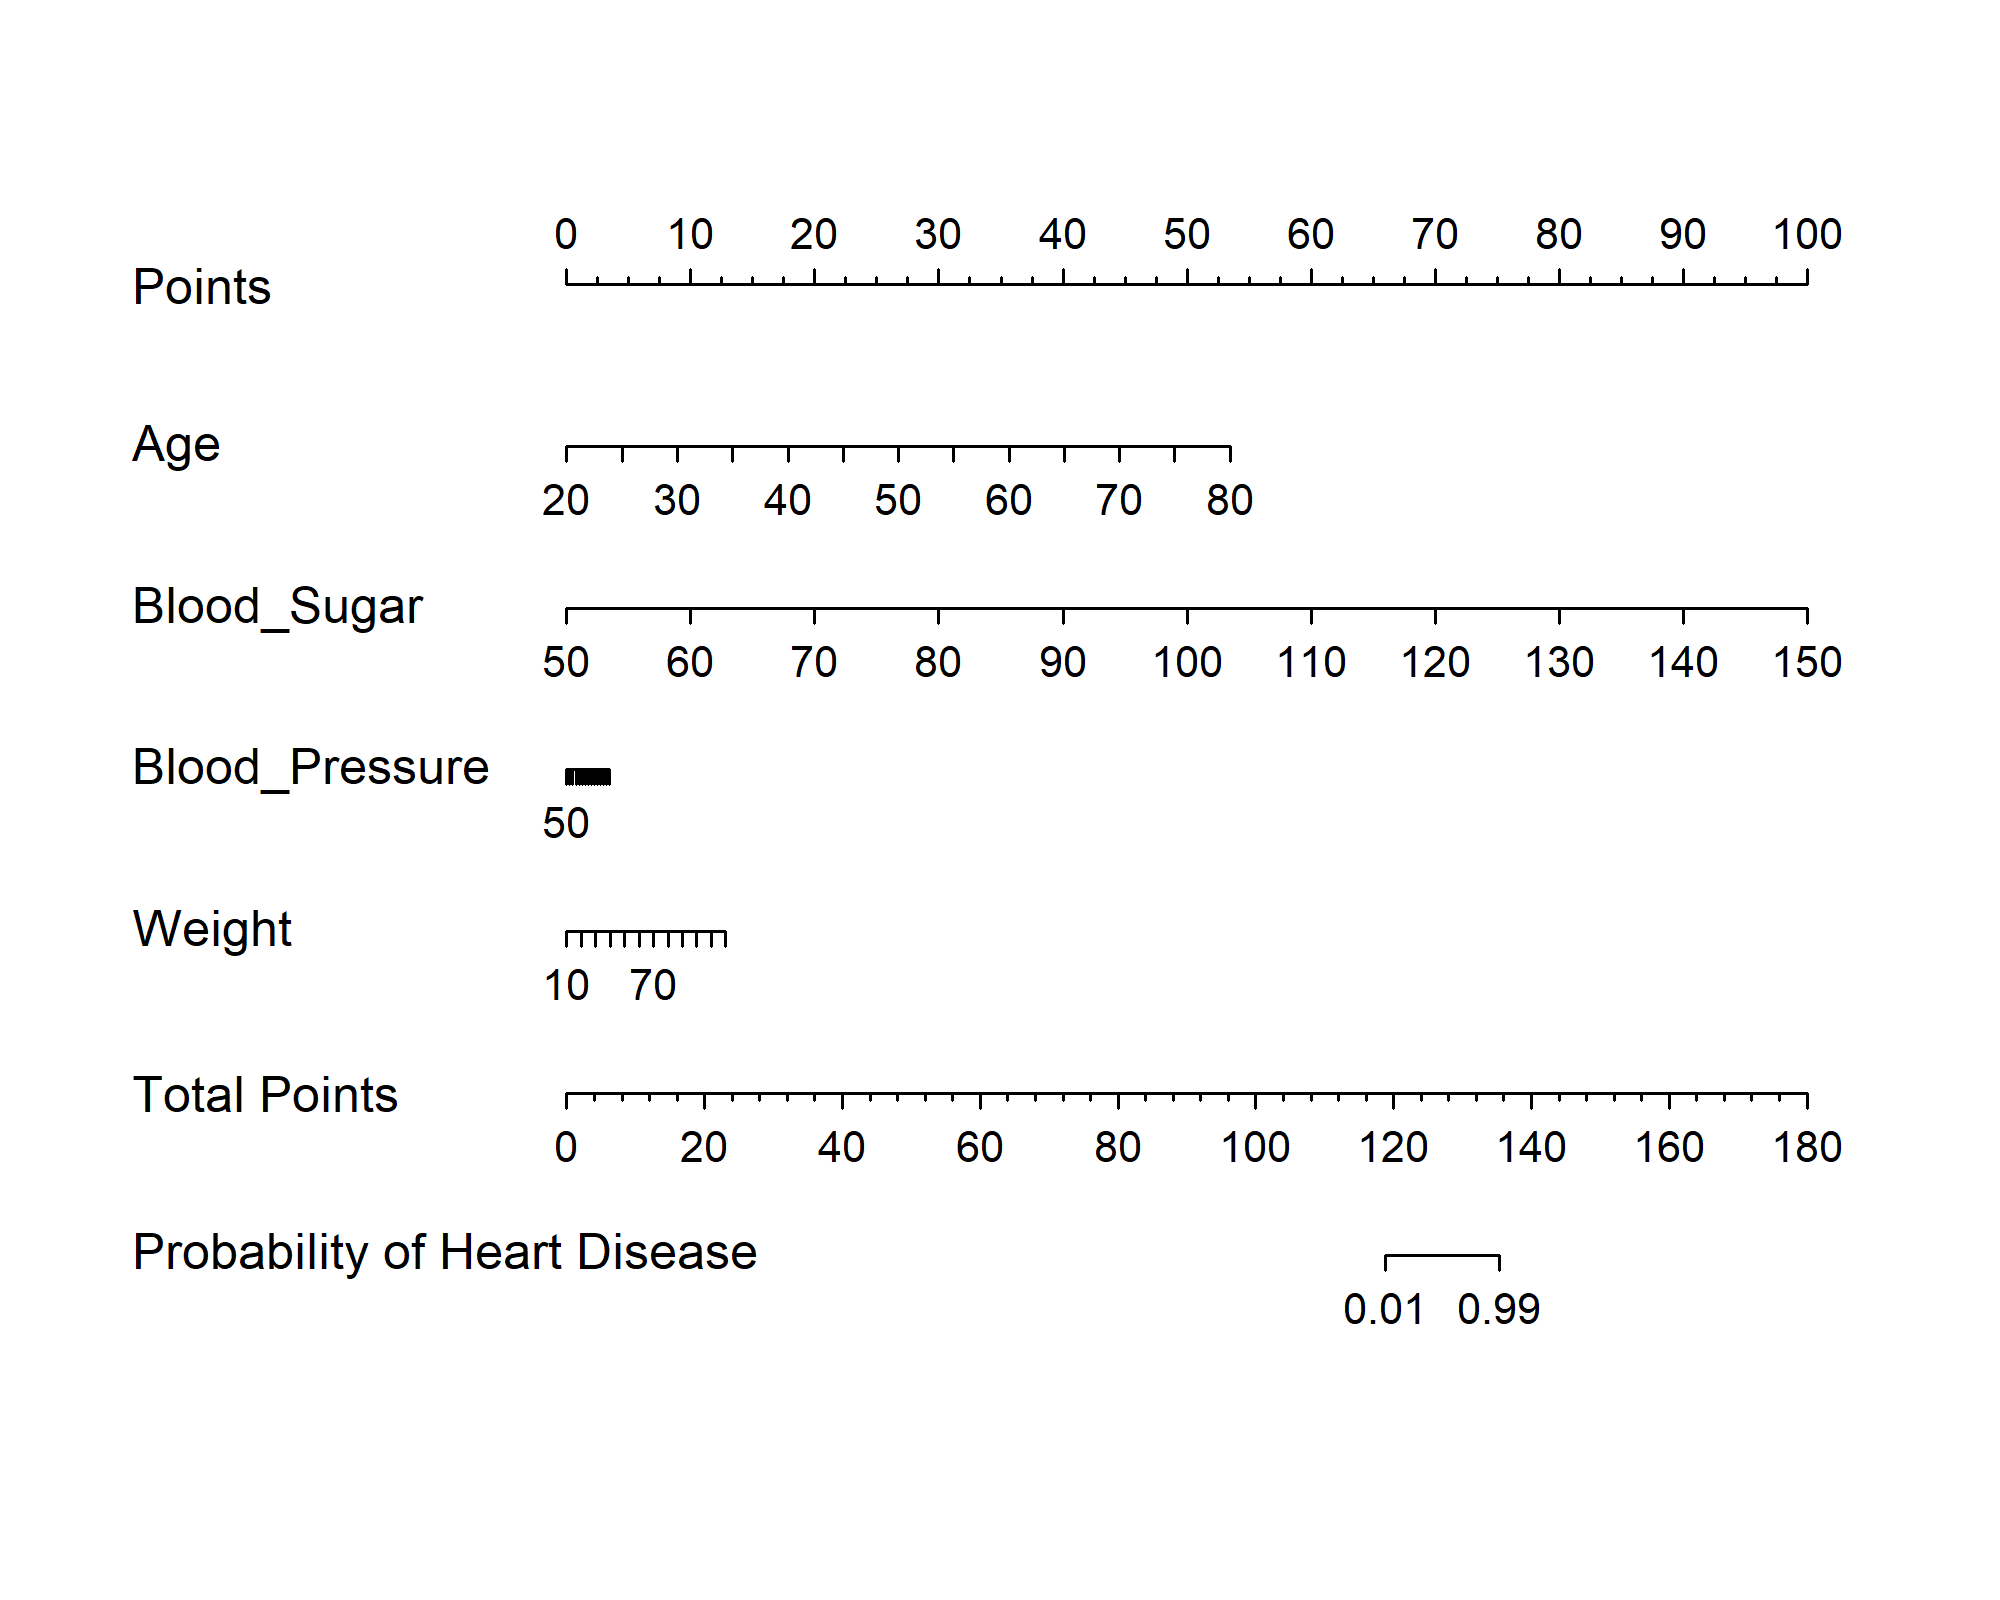

In [13]:
# 显示图像
display(Image(filename="nom.png"))

# 封装R-Executor

[R-Executor](https://github.com/AFAN-LIFE/R-Executor/tree/main)

R-Executor 是一个基于 Docker 的 R 语言执行环境，集成了 R 语言运行时和 Python 的 Flask 服务。通过 HTTP 请求，用户可以将 R 代码发送到 r-executor 容器中执行，并获取结果。该项目旨在提供一个跨平台的 R 语言调用解决方案，简化 R 代码的远程执行和结果获取。